In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch
import matplotlib.gridspec as gridspec
from matplotlib import rc

import osmnx as ox
import networkx as nx

In [2]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [3]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???
# Milano                               (Italy)              EPSG:6875 ???
# Ljubljana                            (Slovenia)           EPSG:8687 ???

place_name = 'The Hague'

In [4]:
output_folder = 'data'
output_sub_folder = '{}_14Sep2023'.format((place_name).split(',')[0].replace(' ', ''))

if place_name == 'Milano':
    local_crs = 'EPSG:6875'
    
elif place_name == 'Ljubljana':
    local_crs = 'EPSG:8687'
    
elif place_name == 'Utrecht':
    local_crs = 'EPSG:28992'
    
elif place_name == 'The Hague':
    local_crs = 'EPSG:28992'

In [5]:
trip_distances = [300]
buffer = max(trip_distances)

# Load data

In [6]:
if place_name == 'Milano':
    xmin = 1022678.517
    ymin = 5695916.600
    xmax = 1027342.347
    ymax = 5698126.489
    
elif place_name == 'Ljubljana':
    xmin =  1612551.082
    ymin =  5787620.135
    xmax =  1617214.912
    ymax =  5789830.024
    
elif place_name == 'Utrecht':
    xmin =  564607.450
    ymin =  6815369.636
    xmax =  569271.280
    ymax =  6817579.525
    
elif place_name == 'The Hague':
    xmin = 472684.4
    ymin = 6807410.2
    xmax = 479629.8
    ymax = 6811201.6

In [7]:
pointList = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax), Point(xmin, ymin)]
bbox_shape = Polygon([[p.x, p.y] for p in pointList])

place = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[bbox_shape])
place = place.to_crs(local_crs)

In [8]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### City

In [9]:
if place_name == 'Milano':
    barrier_list = [
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_50.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_60more.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_major.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_bus.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_12.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_3.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_tram.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_other.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_blue.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_parks_large.geojson')).set_crs(local_crs)
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_green_large.geojson')).set_crs(local_crs)
    ]
        
elif place_name == 'Ljubljana':
    barrier_list = [
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_50.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_60more.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_major.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_bus.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_12.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_3.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_tram.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_other.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_blue.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_parks_large.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_green_large.geojson')).set_crs(local_crs)
    ]

elif place_name == 'Utrecht':
    barrier_list = [
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_50.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_60more.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_major.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_bus.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_12.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_3.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_tram.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_other.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_blue.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_parks_large.geojson')).set_crs(local_crs)
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_green_large.geojson')).set_crs(local_crs)
    ]
    
elif place_name == 'The Hague':
    barrier_list = [
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_50.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_60more.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_major.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_speed_barrier_bus.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_12.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_3.geojson')).set_crs(local_crs),
        # gpd.read_file(os.path.join(output_folder, output_sub_folder, 'highway_type_barrier_tram.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'railway_barrier_other.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_blue.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_parks_large.geojson')).set_crs(local_crs),
        gpd.read_file(os.path.join(output_folder, output_sub_folder, 'natural_barrier_green_large.geojson')).set_crs(local_crs)
    ]

else:
    barrier_list = [
        highway_speed_barrier_50,
        highway_speed_barrier_60more,
        highway_type_barrier_major,
        highway_type_barrier_bus,
        highway_type_barrier_12,
        highway_type_barrier_3,
        railway_barrier_tram,
        railway_barrier_other,
        natural_barrier_blue,
        natural_barrier_parks_large,
        natural_barrier_green_large]

In [10]:
all_barriers = pd.concat(barrier_list)
all_barriers.reset_index(drop=True, inplace=True)

In [11]:
safe_crossings = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'safe_crossings.geojson')).set_crs(local_crs)

In [12]:
playground_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'playground_attraction.geojson')).set_crs(local_crs)
schoolyard_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'schoolyard_attraction.geojson')).set_crs(local_crs, allow_override=True)
small_park_attraction = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'small_park_attraction.geojson')).set_crs(local_crs)

In [13]:
paths = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'paths.geojson')).set_crs(local_crs)

In [14]:
playground_euclidean_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'playground_euclidean_access.geojson')).set_crs(local_crs)

playground_network_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'playground_network_access.geojson')).set_crs(local_crs)

schoolyard_network_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'schoolyard_network_access.geojson')).set_crs(local_crs)
small_park_network_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'small_park_network_access.geojson')).set_crs(local_crs)

playground_childsplay_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'playground_childsplay_access.geojson')).set_crs(local_crs)
schoolyard_childsplay_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'schoolyard_childsplay_access.geojson')).set_crs(local_crs)
small_park_childsplay_access = gpd.read_file(os.path.join(output_folder, output_sub_folder, 'small_park_childsplay_access.geojson')).set_crs(local_crs)

### Account for safe crossings: pedestrian bridges and tunnels

In [15]:
# excluding safe crossings from barriers
all_barriers_nosafecrossing = gpd.GeoDataFrame(
    all_barriers.unary_union.difference(safe_crossings.unary_union)).rename(
    columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)

## Set Geometry types

In [16]:
def set_types_geometries(df, cols, crs):
    for col in cols:
        df[col] = gpd.GeoSeries.from_wkt(df[col])
        gdf = gpd.GeoDataFrame(df, geometry=col).set_crs(crs)

In [17]:
cols = []
for trip_dist in trip_distances:
    cols.append('geom_eucl_'+str(trip_dist))
    
set_types_geometries(playground_euclidean_access, cols, local_crs)

In [18]:
cols = []
for trip_dist in trip_distances:
    cols.append('geom_iso_'+str(trip_dist))

set_types_geometries(playground_network_access, cols, local_crs)
set_types_geometries(schoolyard_network_access, cols, local_crs)
set_types_geometries(small_park_network_access, cols, local_crs)
set_types_geometries(playground_childsplay_access, cols, local_crs)
set_types_geometries(schoolyard_childsplay_access, cols, local_crs)
set_types_geometries(small_park_childsplay_access, cols, local_crs)

## Plot child's play metric

In [19]:
trip_labels = []
for trip_distance in trip_distances:
    trip_labels.append('Within {}m walk'.format(trip_distance))

In [20]:
trip_labels_independent = []
for trip_distance in trip_distances:
    trip_labels_independent.append('Within an independent {}m walk'.format(trip_distance))

In [21]:
color_barr = '#ffbe7a'  #fc8d59'
width_barr = 5
color_path = 'black'
width_path = 0.5
color_popu = 'grey'  #'#eeeeee'
size_popu = 50
alpha_popu =  0.25
size_popu = 1000

color_play = '#a270d1'
color_play_access = '#d0b7e8'

color_scho = '#7abbff'
color_scho_access = '#bcddff'

color_park = '#95cc61'
color_park_access = '#cae5b0'

alpha_access = 0.75

fontsize_main = 50
fontsize_sub = 40
fontsize_legend = 30

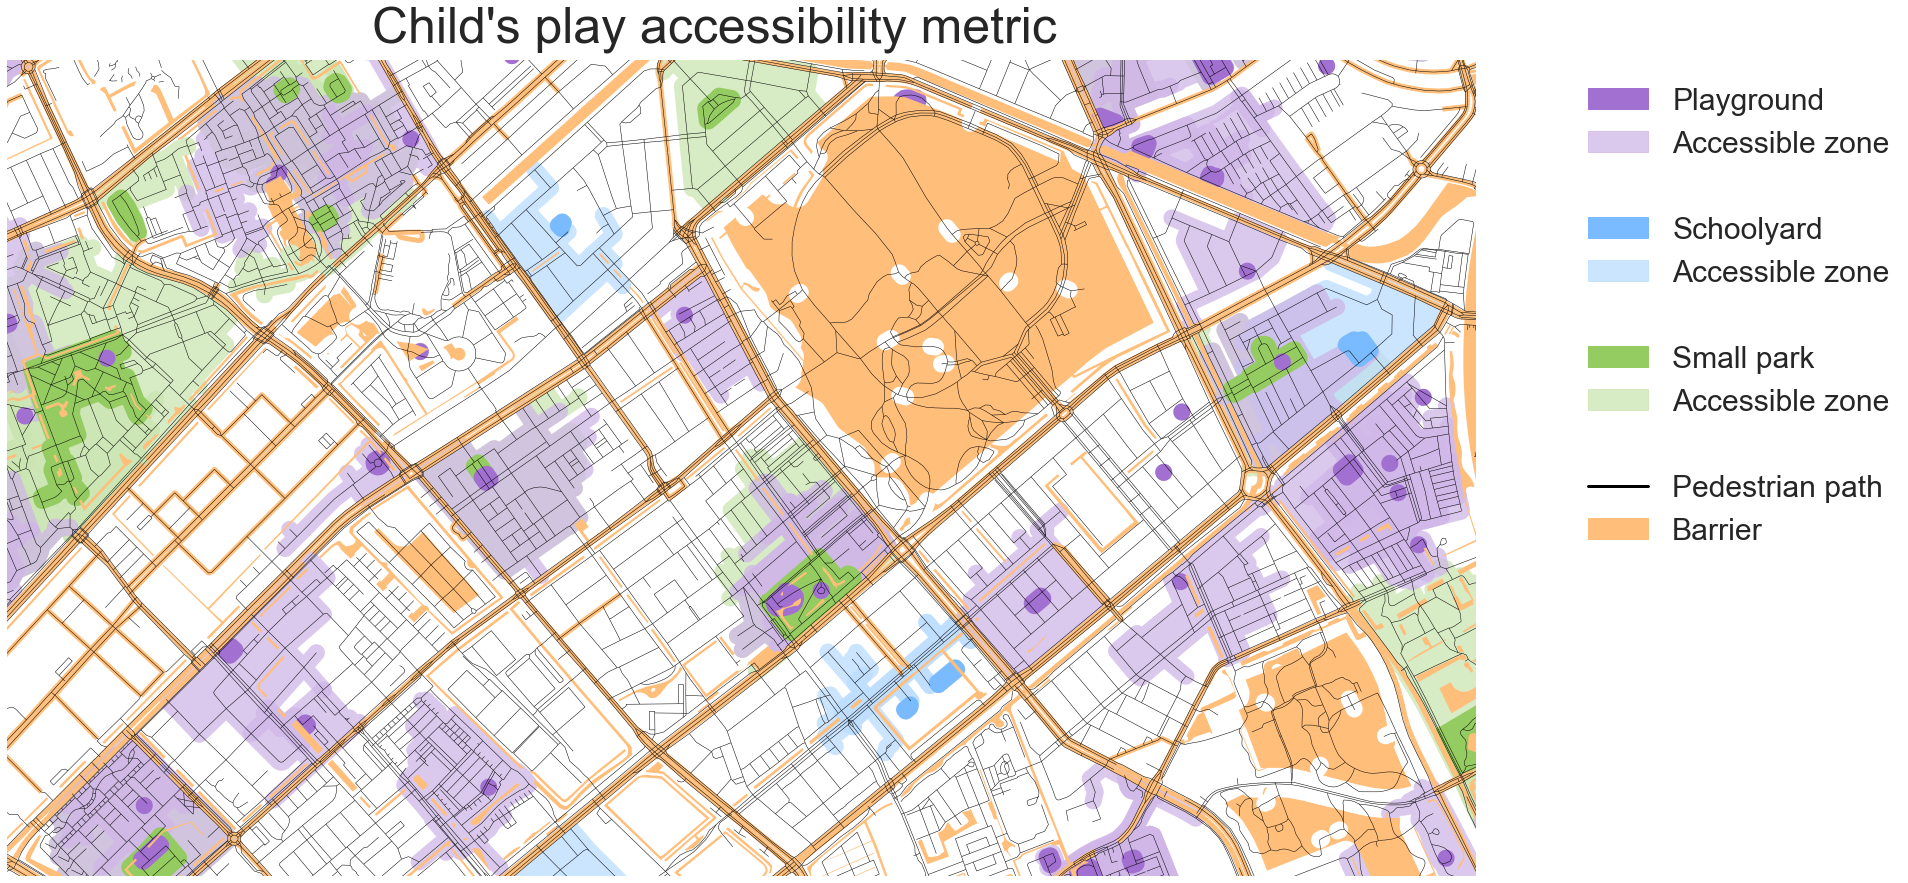

In [22]:
fig, axs = plt.subplots(figsize=(30,15))
fig.suptitle('Child\'s play accessibility metric', fontsize=fontsize_main, y=0.93)


# Utrecht
playground_childsplay_access.set_geometry(('geom_iso_300')).plot(ax=axs, color=color_play_access, alpha=alpha_access, zorder=4)
schoolyard_childsplay_access.set_geometry(('geom_iso_300')).plot(ax=axs, color=color_scho_access, alpha=alpha_access, zorder=3)
small_park_childsplay_access.set_geometry(('geom_iso_300')).plot(ax=axs, color=color_park_access, alpha=alpha_access, zorder=2)
playground_childsplay_access.plot(ax=axs, color=color_play, zorder=7)
schoolyard_childsplay_access.plot(ax=axs, color=color_scho, zorder=6)
small_park_childsplay_access.plot(ax=axs, color=color_park, zorder=5)
all_barriers_nosafecrossing.plot(ax=axs, color=color_barr, linewidth=width_barr, zorder=8)
paths.plot(ax=axs, color=color_path, linewidth=width_path, zorder=9)


# Legend, once
handles = [
    mpatches.Patch(color=color_play, label='Playground'),
    mpatches.Patch(color=color_play_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_scho, label='Schoolyard'),
    mpatches.Patch(color=color_scho_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_park, label='Small park'),
    mpatches.Patch(color=color_park_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mlines.Line2D([], [], color=color_path, linewidth=3, label='Pedestrian path'), 
    mpatches.Patch(color=color_barr, label='Barrier')]
axs.legend(handles=handles, loc='upper right', fontsize=fontsize_legend, bbox_to_anchor=(1.3, 1))



axs.set_xlim(([place.total_bounds[0], place.total_bounds[2]]))
axs.set_ylim(([place.total_bounds[1], place.total_bounds[3]]))
    

axs.axis('off')
    

plt.show()